# Simulation of PCNM/PCoA for Equally Spaced Points

This notebook demonstrates how to simulate the principal coordinate (PCOORD) vectors arising from a principal coordinate analysis (PCoA) of a truncated Euclidean distance matrix among 100 equally spaced objects.  The truncation sets distances beyond the first neighbours to a large constant, mimicking the approach used in PCNM (Principal Coordinates of Neighbour Matrices).

We create 100 points along a one‐dimensional line, compute their pairwise distances, truncate distances greater than 1 to 4, perform PCoA on the resulting distance matrix, and plot selected principal coordinate vectors.  These vectors resemble sine and cosine waves of increasing frequency, similar to those shown in the reference figure.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# Number of objects
n = 100

# Coordinates: equally spaced along a line (0, 1, 2, ..., 99)
coords = np.arange(0, 2 * n, 2).reshape(-1, 1).astype(float)

# Compute Euclidean distance matrix (1D: absolute differences)
D = np.abs(coords - coords.T)

# Truncation threshold: first neighbour distance is 1
d0 = 2

# Construct truncated distance matrix: distances > d0 become 4*d0
T = np.where(D <= d0, D, 4.0 * d0)

# Square the distances and double center
J = np.eye(n) - np.ones((n, n)) / n
A = -0.5 * J.dot(T**2).dot(J)

# Eigen decomposition
evals, evecs = eigh(A)
# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(evals)[::-1]
evals = evals[idx]
evecs = evecs[:, idx]

# Select only positive eigenvalues (ignore very small negatives due to numerical error)
pos_mask = evals > 1e-8
evals_pos = evals[pos_mask]
evecs_pos = evecs[:, pos_mask]

# Scale eigenvectors by sqrt of eigenvalues to obtain PCNM vectors
pcnm_vectors = evecs_pos * np.sqrt(evals_pos)

print(f'Number of positive eigenvalues: {len(evals_pos)}')

Number of positive eigenvalues: 67


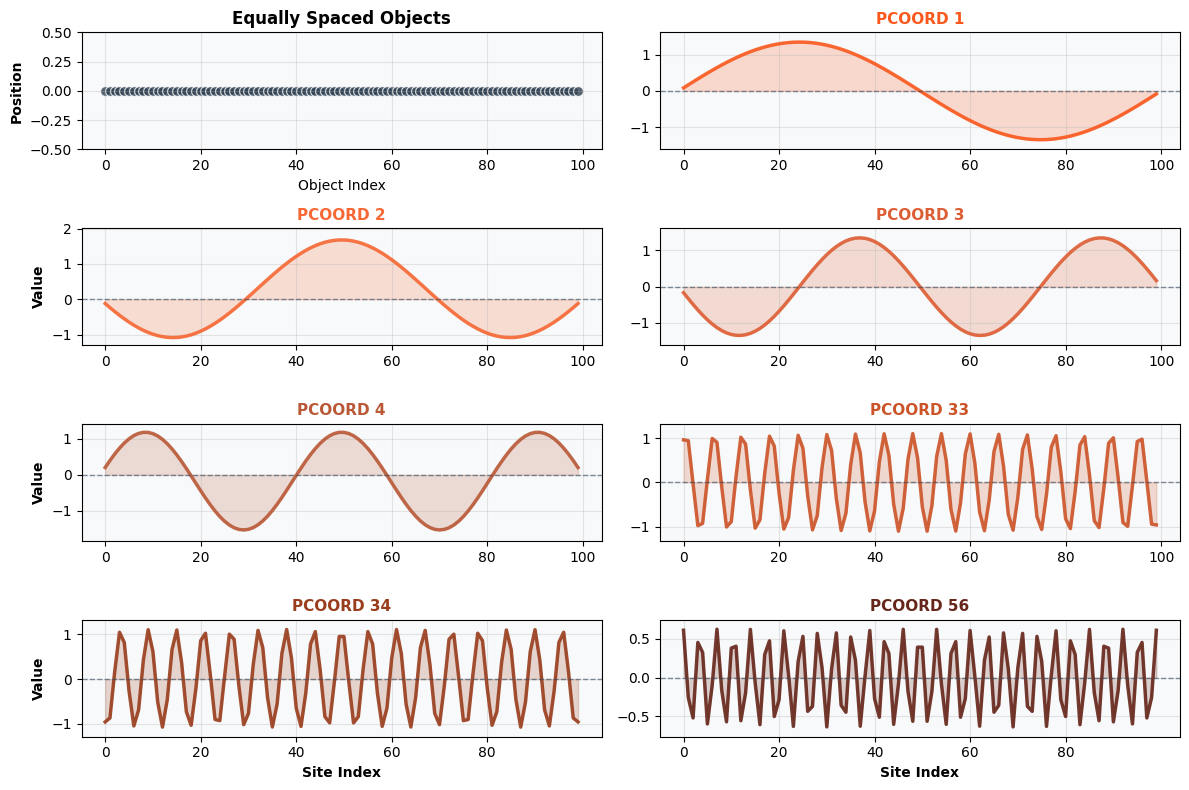

In [6]:
# Plot equally spaced objects and selected PCNM vectors (principal coordinates)
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
axes = axes.flatten()

# Define an energetic color palette
colors = ["#FA581D", "#F66834", "#DD5E34", "#B95937", '#CC5429', '#993D1D', '#66261A', '#4D1C14']

# First plot: equally spaced objects
ax = axes[0]
ax.scatter(range(n), [0]*n, c='#2C3E50', s=50, edgecolor='white', linewidth=0.8, alpha=0.8)
ax.set_title('Equally Spaced Objects', fontweight='bold', fontsize=12)
ax.set_xlabel('Object Index')
ax.set_ylabel('Position')
ax.set_ylim(-0.5, 0.5)
ax.grid(True, alpha=0.3)
ax.set_facecolor('#F8F9FA')

# Rest 7 plots: selected PCOORD vectors as waves
# Choose the 1st, 2nd, 3rd, 4th, 33rd, 34th, 56th and 61st (1-indexed)
indices = [0, 1, 2, 3, 32, 33, 55, 60]  # 0-based indices
labels = [f'PCOORD {i+1}' for i in indices]

for i, (ax, idx, lbl, color) in enumerate(zip(axes[1:], indices, labels, colors)):
    vec = pcnm_vectors[:, idx]
    ax.plot(vec, color=color, linewidth=2.5, alpha=0.9)
    ax.fill_between(range(len(vec)), vec, alpha=0.2, color=color)
    ax.axhline(0, color='#34495E', linewidth=1, alpha=0.6, linestyle='--')
    ax.set_title(lbl, fontweight='bold', fontsize=11, color=color)
    ax.set_ylim(vec.min()*1.2, vec.max()*1.2)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#F8F9FA')

# Set x-axis ticks and labels for bottom row
for ax in axes[6:8]:
    ax.set_xticks([0, 20, 40, 60, 80])
    ax.set_xlabel('Site Index', fontweight='bold')

# Set y-axis labels
axes[0].set_ylabel('Position', fontweight='bold')
axes[2].set_ylabel('Value', fontweight='bold')
axes[4].set_ylabel('Value', fontweight='bold')
axes[6].set_ylabel('Value', fontweight='bold')

plt.tight_layout()
plt.savefig("../results/preliminary_results/pcnm_simulation_1d_equally_spaced.png", dpi=300)
plt.show()

## Regular (Equally Spaced) Sites on 2D coordinate: PCNM / MEM Example (Restored)

### PCNM / MEM on an Equally Spaced 2D Grid (Referencing the Irregular Example Above)
We now complement the irregular (clustered + scattered) site example with a *regularly spaced* 2D lattice of sites. This contrast helps illustrate how spatial eigenfunctions (PCNMs / MEMs) behave when spacing is uniform:

Key points versus the irregular case:
- Distance threshold: with a perfect grid the maximum nearest-neighbour distance equals the grid spacing; this yields a highly connected truncation at the *MST longest edge*.
- Eigenvalue spectrum: regular spacing often produces clearer spatial frequency ordering (low‐frequency broad gradients to high‐frequency checkerboard patterns).
- Moran's I: For a given binary neighbourhood (within threshold) early (broad-scale) eigenvectors usually have larger positive Moran's I; high-frequency ones may approach zero or negative.

Procedure (same core steps):
1. Generate coordinates on a square grid (e.g., G x G points).
2. Compute Euclidean distance matrix D.
3. Determine truncation threshold d0 = max nearest-neighbour distance (equivalently longest MST edge here).
4. Build truncated matrix T (replace distances > d0 by large penalty 4*d0) so that local neighbourhood structure drives centring.
5. Double‑center (Gower transform) A = -1/2 J T^{∘2} J.
6. Eigen-decompose A; retain eigenvectors with positive eigenvalues.
7. Compute Moran's I for each retained eigenvector using a binary connectivity matrix W (distance <= d0, zero diagonal).
8. Select the top K eigenvectors by Moran's I (broad-scale positive autocorrelation) and visualise them as smooth spatial gradients.

Below: code reproducing these steps and plotting (a) grid sites, (b) Moran's I vs eigenvalue index, and (c) maps of the first few broad-scale PCNMs.

You can later: (i) vary grid spacing or add jitter to examine sensitivity, (ii) compare cumulative variance vs Moran's I ordering, (iii) feed selected eigenvectors into downstream regression / quantile models as spatial covariates S_sel.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse import csgraph

# -------------------------------
# 1. Generate regular grid points
# -------------------------------
G = 15  # grid side length (G x G points)
x_coords = np.linspace(0, 1, G)
y_coords = np.linspace(0, 1, G)
Xg, Yg = np.meshgrid(x_coords, y_coords)
coords = np.column_stack([Xg.ravel(), Yg.ravel()])  # (G^2, 2)
n = coords.shape[0]

# ---------------------------------------------
# 2. Distance matrix and nearest-neighbour dist
# ---------------------------------------------
D = distance_matrix(coords, coords)
np.fill_diagonal(D, 0.0)
# nearest-neighbour distance per site
nn_dist = np.partition(D + np.eye(n)*1e9, 1, axis=1)[:,1]
# threshold = maximum nearest-neighbour distance (regular grid => spacing)
d0 = nn_dist.max()

# Verification via MST (for consistency with irregular example)
MST = csgraph.minimum_spanning_tree(D)
longest_mst_edge = MST.data.max()
assert abs(longest_mst_edge - d0) < 1e-9, "Mismatch between max NN distance and MST longest edge on grid."

# ----------------------------------------------------
# 3. Truncated distance matrix T (penalize far pairs)
# ----------------------------------------------------
T = D.copy()
penalty = 4 * d0
T[T > d0] = penalty

# ---------------------------------------
# 4. Double-centering (Gower transform)
# ---------------------------------------
J = np.eye(n) - np.ones((n,n))/n
A = -0.5 * J @ (T**2) @ J

# ---------------------------------------
# 5. Eigen decomposition & retain positives
# ---------------------------------------
vals, vecs = np.linalg.eigh((A + A.T)/2)  # symmetrize for numerical stability
idx = np.argsort(vals)[::-1]
vals = vals[idx]
vecs = vecs[:, idx]
positive_mask = vals > 1e-9
vals_pos = vals[positive_mask]
vecs_pos = vecs[:, positive_mask]

# ---------------------------------------
# 6. Moran's I for each retained eigenvector
# ---------------------------------------
W = (D <= d0).astype(float)
np.fill_diagonal(W, 0.0)
S0 = W.sum()

moran_I = []
for k in range(vecs_pos.shape[1]):
    z = vecs_pos[:,k]
    zc = z - z.mean()
    num = (zc[:,None] * zc[None,:] * W).sum()
    den = (zc**2).sum()
    I_k = (n / S0) * (num / den)
    moran_I.append(I_k)

moran_I = np.array(moran_I)

# Select top K eigenvectors by Moran's I (broad-scale positive autocorrelation)
K = 6
sel_idx = np.argsort(moran_I)[::-1][:K]
sel_I = moran_I[sel_idx]
sel_vecs = vecs_pos[:, sel_idx]

# ---------------------------------------
# 7. Visualization
# ---------------------------------------
fig = plt.figure(figsize=(15, 11))

# (a) Grid of sites
ax1 = fig.add_subplot(2, 3, 1)
ax1.scatter(coords[:,0], coords[:,1], s=15, c='k')
ax1.set_title('(a) Regular grid sites')
ax1.set_xticks([]); ax1.set_yticks([])

# (b) Moran's I vs eigenvector index
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(range(1, len(moran_I)+1), moran_I, 'o-', markersize=3)
ax2.scatter(sel_idx+1, sel_I, color='red', label='Selected (top Moran I)')
ax2.set_xlabel('Eigenvector index (positive λ)')
ax2.set_ylabel("Moran's I")
ax2.set_title("(b) Moran's I of retained eigenvectors")
ax2.legend(fontsize=8)
# (c-f) Selected eigenvectors spatial patterns
for j in range(K):
    if j < 4:  # Only plot first 4 eigenvectors to fit in 2x3 grid
        ax = fig.add_subplot(2, 3, 3 + j)
        pattern = sel_vecs[:, j]
        sc = ax.scatter(coords[:,0], coords[:,1], c=pattern, cmap='RdBu', s=25)
        ax.set_title(f'(c{j+1}) PCNM {sel_idx[j]+1}\n Moran\'s I={sel_I[j]:.2f}, λ={vals_pos[sel_idx[j]]:.3f}')
        ax.set_xticks([]); ax.set_yticks([])

# Add a colorbar for the last plotted eigenvector
plt.tight_layout()
# cbar = plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, 
#                    shrink=0.8, aspect=30)
plt.colorbar(sc, ax=fig.get_axes(), orientation='horizontal', fraction=0.05, pad=0.1, 
                   shrink=0.8, aspect=30)
plt.savefig("../results/preliminary_results/pcnm_simulation_2d_equally_spaced.png", dpi=300)
plt.show()

print(f"Grid size: {G}x{G} -> n={n}\nThreshold d0={d0:.4f} (spacing).  Positive eigenvectors: {len(vals_pos)}")
print("Top selected Moran's I:")
for rank,(i_val,Iv) in enumerate(zip(sel_idx, sel_I), start=1):
    print(f"  Rank {rank}: EV index {i_val+1}, I={Iv:.4f}")


Grid size: 15x15 -> n=225
Threshold d0=0.0714 (spacing).  Positive eigenvectors: 156
Top selected Moran's I:
  Rank 1: EV index 1, I=1.0204
  Rank 2: EV index 2, I=1.0204
  Rank 3: EV index 3, I=0.9899
  Rank 4: EV index 4, I=0.9853
  Rank 5: EV index 5, I=0.9709
  Rank 6: EV index 6, I=0.9404


## Irregular (Unequally Spaced) Sites: PCNM / MEM Example (Restored)
This section recreates the example for clustered + scattered sites to derive spatial eigenvectors:
1. Simulate irregular coordinates (two clusters + background points).
2. Compute Euclidean distances (replace with network distances for rivers if needed).
3. Set truncation threshold d0 = max nearest-neighbour distance (ensures connectivity like MST longest edge).
4. Build truncated distance matrix and perform PCoA (classic PCNM).
5. Keep positive eigenvalues as candidate spatial predictors (broad → fine scale).
6. Compute Moran's I for each eigenvector using a binary neighbour matrix (distance ≤ d0) to assess spatial autocorrelation.
7. Plot top Moran's I eigenvectors.

Use selected eigenvectors as spatial covariates in models (same set across quantiles) to control residual spatial autocorrelation before interpreting contamination effects.


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata

# --- 1. Simulate irregular (clustered + scattered) site coordinates ---
np.random.seed(42)
cluster1 = np.random.normal(loc=(10, 10), scale=1.0, size=(30, 2))
cluster2 = np.random.normal(loc=(30, 25), scale=1.5, size=(25, 2))
background = np.random.uniform(low=[0, 0], high=[40, 30], size=(25, 2))
coords = np.vstack([cluster1, cluster2, background])
n = coords.shape[0]

# --- 2. Euclidean distance matrix ---
D = distance_matrix(coords, coords)

# --- 3. Truncation threshold d0 = max nearest-neighbour distance ---
nearest = np.sort(D + np.eye(n) * 1e9, axis=1)[:, 0]
# d0 = nearest.max()
d0 = 5
print(f"Chosen d0 (max nearest-neighbour distance): {d0:.3f}")

# --- 4. Truncate distances (classic PCNM) ---
T = np.where(D <= d0, D, 4.0 * d0)

# --- 5. Double centering of squared truncated distances ---
J = np.eye(n) - np.ones((n, n)) / n
A = -0.5 * J @ (T ** 2) @ J

# --- 6. Eigen decomposition ---
vals, vecs = eigh(A)
idx = np.argsort(vals)[::-1]
vals = vals[idx]
vecs = vecs[:, idx]

# --- 7. Keep positive eigenvalues ---
pos_mask = vals > 1e-10
vals_pos = vals[pos_mask]
vecs_pos = vecs[:, pos_mask]
pcnm_vectors = vecs_pos * np.sqrt(vals_pos)
print(f"Positive eigenvectors retained: {pcnm_vectors.shape[1]}")

# --- 8. Moran's I for each eigenvector using binary neighbourhood (distance <= d0) ---
W = (D <= d0).astype(float)
np.fill_diagonal(W, 0)
row_sums = W.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
W_std = W / row_sums

def morans_I(z, W):
    zc = z - z.mean()
    num = (zc[:, None] * W * zc[None, :]).sum()
    den = (zc ** 2).sum()
    nloc = len(z)
    return (nloc / W.sum()) * (num / den)

morans = [morans_I(pcnm_vectors[:, i], W_std) for i in range(pcnm_vectors.shape[1])]
order = np.argsort(morans)[::-1]
selected_indices = order[:8]
print("Top Moran's I (first 8):")


fig, axes = plt.subplots(2, 3, figsize=(17, 11))
axes = axes.flatten()
# print(f"PCNM {i+1}: Moran's I = {morans[i]:.3f}")
# --- 9. Plot selected eigenvectors ---
# First plot: distribution of all original sites
ax = axes[0]
ax.scatter(coords[:, 0], coords[:, 1], c='black', s=40, edgecolor='k', linewidth=0.4)
ax.grid(True, alpha=0.4, linestyle='--')
ax.set_title('Original Site Distribution')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_aspect('equal')

# (b) Moran's I profile
ax2 = axes[1]
ax2.plot(range(1,len(morans)+1), morans, 'o-', markersize=3)
ax2.scatter(selected_indices+1, [morans[i] for i in selected_indices], color='red', label='Selected')
ax2.set_xlabel('Eigenvector index (positive λ)')
ax2.set_ylabel("Moran's I")
ax2.set_title("(b) Moran's I of eigenvectors")
# ax2.legend(fontsize=8)

# Rest 5 plots: selected PCNM vectors as density heatmaps

# Create a regular grid for interpolation
x_min, x_max = coords[:, 0].min() - 2, coords[:, 0].max() + 2
y_min, y_max = coords[:, 1].min() - 2, coords[:, 1].max() + 2
xi = np.linspace(x_min, x_max, 100)
yi = np.linspace(y_min, y_max, 100)
Xi, Yi = np.meshgrid(xi, yi)

plt.subplots_adjust(hspace=2)

for i, (ax, idx) in enumerate(zip(axes[2:], selected_indices[:5])):
    # Interpolate PCNM values to regular grid
    zi = griddata((coords[:, 0], coords[:, 1]), pcnm_vectors[:, idx], 
                    (Xi, Yi), method='cubic', fill_value=0)
    
    # Create density heatmap
    im = ax.contourf(Xi, Yi, zi, levels=20, cmap='coolwarm', alpha=0.8)
    
    # Overlay original points
    ax.scatter(coords[:, 0], coords[:, 1], c=pcnm_vectors[:, idx], 
                cmap='coolwarm', s=40, edgecolor='k', linewidth=0.4)
    
    # Add eigenvalue to the title
    ax.set_title(f"PCNM {idx+1}\nMoran-Index={morans[idx]:.2f}, λ={vals_pos[idx]:.1f}")
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.4, linestyle='--')

fig.suptitle('Irregular Sampling: Original Sites + Selected Spatial Eigenvectors (Density)')
plt.tight_layout()
# Create a colorbar with better styling
cbar = plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, 
                   shrink=0.6, aspect=30)
cbar.set_label('PCNM Values', fontsize=10, fontweight='bold')
cbar.ax.tick_params(labelsize=10)
plt.savefig("../results/preliminary_results/pcnm_simulation_2d_randomly_spaced.png", dpi=300)
plt.show()

# --- 10. Variance explained by eigenvalues (first 10) ---
var_explained = vals_pos / vals_pos.sum()
print("Cumulative variance fractions (first 10):", np.cumsum(var_explained)[:10])

Chosen d0 (max nearest-neighbour distance): 5.000
Positive eigenvectors retained: 30
Top Moran's I (first 8):


Cumulative variance fractions (first 10): [0.39635776 0.53789162 0.59303567 0.64335054 0.68841962 0.72892029
 0.76358509 0.79494462 0.82490021 0.84970283]


## Read the Detroit River data with geo-information

In [40]:
# read the data with spatial information
import pandas as pd
data = pd.read_excel('../data/environmental_Copy_of_RelMax_classification_with_clusters_and_REFsite_to_predict_test_sites.xlsx')
data.head()

Unnamed: 0      LLOI    LDepth     LTemp       LDO  LVelocity  MPS (Phi)  \
0       001A  0.290035  0.402089  1.230449  1.041393   0.065811   3.000000   
1     003ABC  0.330414  0.841585  1.204120  1.033424   0.137310   0.555556   
2     004ABC  0.250420  0.623291  1.217484  1.064458   0.158902   0.566667   
3     005ABC  0.184691  0.346196  1.255273  1.000000   0.034291   0.642857   
4       006B  0.243038  0.427551  1.267172  1.017033   0.049412   0.700000   

    Latitude  Longitude  
0  42.346447 -82.918068  
1  42.353685 -82.944344  
2  42.350308 -82.934247  
3  42.342434 -82.945587  
4  42.343560 -82.941871

### PCNM / MEM on Detroit River Sites (Projected Latitude/Longitude)
The following cell:
1. Reads site latitude/longitude (already loaded into `data`).
2. Drops rows with missing or duplicate coordinates.
3. Projects geographic coordinates (EPSG:4326) to an equal-area CRS suitable for Great Lakes scale (EPSG:3175 NAD83 / Great Lakes and St Lawrence Albers) to reduce distortion.
4. Computes pairwise Euclidean distances in projected meters.
5. Determines truncation threshold d0 = longest edge of the minimum spanning tree (equivalently max nearest-neighbour distance) ensuring connectivity.
6. Builds truncated distance matrix (penalizing distances > d0 with 4*d0), double-centers squared distances, eigen-decomposes, and retains positive eigenvalues.
7. Computes Moran's I for each eigenvector using a binary neighbourhood (distance ≤ d0) and selects top K broad-scale spatial eigenvectors.
8. Visualizes (a) site map, (b) Moran's I profile, (c–f) spatial patterns of selected eigenvectors.
Outputs are saved to `../results/preliminary_results/pcnm_simulation_detroit_river.png` for inclusion in the report.

Note: Change CRS if a finer local projection is preferred (e.g., UTM zone covering Detroit River).

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse import csgraph
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 1. Extract & clean coordinates
# -------------------------------
required_cols = [c for c in ['Latitude','longitude','Longitude','LAT','LON'] if c in data.columns]
if 'Latitude' in data.columns and 'Longitude' in data.columns:
    lat_col, lon_col = 'Latitude','Longitude'
elif 'Latitude' in data.columns and 'longitude' in data.columns:
    lat_col, lon_col = 'Latitude','longitude'
else:
    raise ValueError(f'Could not find latitude/longitude columns in: {data.columns.tolist()}')

geo = data[[lat_col, lon_col]].copy().rename(columns={lat_col:'lat', lon_col:'lon'})
geo = geo.dropna().drop_duplicates()
n_sites_initial = len(geo)

# -------------------------------
# 2. Project to equal-area CRS (EPSG:3175 Great Lakes)
# -------------------------------
try:
    import pyproj
    proj_in = pyproj.CRS('EPSG:4326')
    proj_out = pyproj.CRS('EPSG:3175')  # NAD83 / Great Lakes and St Lawrence Albers
    transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)
    x_proj, y_proj = transformer.transform(geo['lon'].values, geo['lat'].values)
except Exception as e:
    raise RuntimeError('pyproj is required for projection; install via pip if missing.') from e

coords = np.column_stack([x_proj, y_proj])
n = coords.shape[0]
print(f'Projected {n} unique sites (from {n_sites_initial} raw rows).')

# -------------------------------
# 3. Distance matrix and threshold via MST
# -------------------------------
D = distance_matrix(coords, coords)
np.fill_diagonal(D, 0.0)
# nearest-neighbour distances
nn_dist = np.partition(D + np.eye(n)*1e12, 1, axis=1)[:,1]
# Threshold: longest edge of MST (ensures connectivity)
MST = csgraph.minimum_spanning_tree(D)
d0 = MST.data.max()
print(f'Truncation threshold d0 (longest MST edge): {d0:,.2f} m')

# -------------------------------
# 4. Truncated distance matrix
# -------------------------------
penalty = 4 * d0
T = D.copy()
T[T > d0] = penalty

# -------------------------------
# 5. Double-centering (Gower)
# -------------------------------
J = np.eye(n) - np.ones((n,n))/n
A = -0.5 * J @ (T**2) @ J

# -------------------------------
# 6. Eigen decomposition
# -------------------------------
vals, vecs = np.linalg.eigh((A + A.T)/2)
idx = np.argsort(vals)[::-1]
vals = vals[idx]; vecs = vecs[:, idx]
pos_mask = vals > 1e-9
vals_pos = vals[pos_mask]
vecs_pos = vecs[:, pos_mask]
print(f'Positive eigenvectors retained: {len(vals_pos)}')

# -------------------------------
# 7. Moran's I for spatial eigenvectors
# -------------------------------
W = (D <= d0).astype(float)
np.fill_diagonal(W, 0.0)
S0 = W.sum()

moran_I = []
for k in range(vecs_pos.shape[1]):
    z = vecs_pos[:,k]
    zc = z - z.mean()
    num = (zc[:,None] * zc[None,:] * W).sum()
    den = (zc**2).sum()
    moran_I.append( (n / S0) * (num / den) )
moran_I = np.array(moran_I)

K = min(6, len(moran_I))
sel_idx = np.argsort(moran_I)[::-1][:K]
sel_I = moran_I[sel_idx]
sel_vecs = vecs_pos[:, sel_idx]

# -------------------------------
# 8. Visualization
# -------------------------------
fig = plt.figure(figsize=(15, 11))

# (a) Map of sites (projected)
ax1 = fig.add_subplot(2,3,1)
sc1 = ax1.scatter(coords[:,0], coords[:,1], s=18, c='k')
ax1.set_title('(a) Detroit River sites (projected)')
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.set_xlabel('Projected X (m)')
# ax1.set_ylabel('Projected Y (m)')


# (b) Moran's I profile
ax2 = fig.add_subplot(2,3,2)
ax2.plot(range(1,len(moran_I)+1), moran_I, 'o-', markersize=3)
ax2.scatter(sel_idx+1, sel_I, color='red', label='Selected')
ax2.set_xlabel('Eigenvector index (positive λ)')
ax2.set_ylabel("Moran's I")
ax2.set_title("(b) Moran's I of eigenvectors")
ax2.legend(fontsize=8)

# (c-f) Selected eigenvector spatial patterns
for j in range(K):
    if j < 4:
        ax = fig.add_subplot(2,3,3+j)
        pattern = sel_vecs[:, j]
        sp = ax.scatter(coords[:,0], coords[:,1], c=pattern, cmap='RdBu', s=28)
        ax.set_title(f'(c{j+1}) PCNM {sel_idx[j]+1}\n I={sel_I[j]:.2f}, λ={vals_pos[sel_idx[j]]:.2e}')
        ax.grid(True, alpha=0.4, linestyle='--')
        # ax.set_xticks([]); ax.set_yticks([])
        

plt.tight_layout()
cbar = plt.colorbar(sp, ax=fig.get_axes(), orientation='horizontal', fraction=0.05, pad=0.1, shrink=0.8, aspect=30)
cbar.set_label('Eigenvector value')
plt.savefig('../results/preliminary_results/pcnm_simulation_detroit_river.png', dpi=300)
plt.show()

print('Top selected Moran\'s I:')
for rank,(i_ev,Iv) in enumerate(zip(sel_idx, sel_I), start=1):
    print(f'  Rank {rank}: EV index {i_ev+1}, Moran I={Iv:.4f}, lambda={vals_pos[i_ev]:.3e}')

Projected 225 unique sites (from 225 raw rows).
Truncation threshold d0 (longest MST edge): 2,354.65 m
Positive eigenvectors retained: 128


Top selected Moran's I:
  Rank 1: EV index 1, Moran I=1.2695, lambda=9.488e+08
  Rank 2: EV index 2, Moran I=1.2393, lambda=9.242e+08
  Rank 3: EV index 3, Moran I=1.0656, lambda=7.986e+08
  Rank 4: EV index 4, Moran I=0.9854, lambda=7.438e+08
  Rank 5: EV index 5, Moran I=0.9503, lambda=7.183e+08
  Rank 6: EV index 6, Moran I=0.9061, lambda=6.868e+08
